# FIT5201: Assessment 3
## Latent Variables and Neural Networks

### Student Name: Ashok Vijaya Suvarna

### Student Number: 29055830

### Recording: https://youtu.be/-CODXL9n7QA

## Objectives
This assignment consists of three parts (A,B,C), which cover latent variables models and neural networks (Modules 4 and 5). The total marks of this assessment is 100.

## Important Note
* You can complete your assignment using the codes shared in the unit (ie Alexandria and Moodle) and this template as the bases. However, <font color='red'>**you should make sure the codes you are using are correct and relevant to the question**</font>.

* Please follow the structure of this template as much as you can.

* You can use the prepopulated codes cells or change them if you prefer. However, please do not change the name of the key variables, functions, and parameters eg `N`, `D`, and `eta`. It helps us to read and understand your submissiont more efficiently.

In [2]:
# Supress warnings
options(warn=-1)

# Load Libraries
library(reshape2)
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(tm) # load Text Mining library
library(plyr)

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



# Part A. Document Clustering
In this part, you solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization for document clustering.

## Question 1 [EM for Document Clustering, 40 Marks]

#### Background of the soft-EM and hard-EM

##### Soft EM  
  **E-Step**
  
  For each cluster $k$, based on its current mixing component $\varphi_k^{old}$, word proportion $\mu_k^{old}$, calculate the posterior probability of the nth document $d_n$ being in cluster $k$, denoted by $\gamma(z_{nk})$
  
  $\gamma(z_{nk}):= p(z_{nk} = 1 \mid d_n, \varphi_k^{old}, \mu_k^{old}) = \frac{\varphi_k^{old}\prod_{w \in \mathcal{A}}\mu_{k,w}^{c(w,d_n)}}{\sum_{j=1}^K\varphi_j^{old}\prod_{w \in \mathcal{A}}\mu_{j,w}^{c(w,d_n)}}$  
  
  **M-Step**
 
  Update the parameters as the following:
  
  mixing components: $\varphi_k^{new} = \frac{N_k}{N}$ where  $N_k = \sum_{n=1}^N \gamma(z_{nk})$  
  word proportion: $\mu_{k,w}^{new} = \frac{\sum_{n=1}^N\gamma(z_{nk})c(w,d_n)}{\sum_{w'\in \mathcal{A}}\sum_{n=1}^N\gamma(z_{nk})c(w',d_n)}$
  
  
##### Hard EM  
  **E-Step**

  For each cluster $k$, based on its current mixing component $\varphi_k^{old}$, word proportion $\mu_k^{old}$, calculate the posterior probability of the nth document $d_n$ being in cluster $k$, denoted by $\gamma(z_{nk})$
  
  $\gamma(z_{nk}):= p(z_{nk} = 1 \mid d_n, \varphi_k^{old}, \mu_k^{old}) = \frac{\varphi_k^{old}\prod_{w \in \mathcal{A}}\mu_{k,w}^{c(w,d_n)}}{\sum_{j=1}^K\varphi_j^{old}\prod_{w \in \mathcal{A}}\mu_{j,w}^{c(w,d_n)}}$  
  
  then set $\gamma_{nk^*}=1$ and everywhere else to 0, where $k^* \leftarrow argmax_k \gamma(z_{nk})$ 
  
  **M-Step**
  
  Update the parameters as the following:
    
  mixing components: $\varphi_k^{new} = \frac{N_k}{N}$ where $N_k = \sum_{n=1}^N \gamma(z_{nk})$  
  word proportion: $\mu_{k,w}^{new} = \frac{\sum_{n=1}^N\gamma(z_{nk})c(w,d_n)}{\sum_{w'\in \mathcal{A}}\sum_{n=1}^N\gamma(z_{nk})c(w',d_n)}$ 

### Q1-1 

Implement the hard-EM and soft-EM provided above. Please provide enough comments in your submitted code.

In [3]:
# hard and soft clustered Gaussian Mixture Models
# X is dataframe of data to cluster, K = number of clusters to form, hardclustering(T/F) for hard(True) or soft(False) clustering
doc.clustering <- function(X, K, hardclustering=FALSE){

    #data derived settings - like sizes
    N <- nrow(X)
    D <- ncol(X)
    # Setting the parameters:
    eta.max <- 100     #100 # maximum number of iterations
    epsilon <- 0.01    #0.01 # termination threshold
    tiny <- 1e-99      # small value to avoid 0 sum normalisation --- Need to use tiny
    # Initialzations:
    eta <- 1            # epoch counter


    ## Random cluster initialization:
    Phi.hat <- 1/K                          # assume all clusters have the same size (we will update this later on)
    Nk.hat <- matrix(N/K,nrow = K)          # refer to the above line!
    Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly  choose K samples as cluster means (any better idea?)
    #Ash Code 5
    Sigma.hat <- matrix(,nrow = K, ncol = D^2) # create empty covariance matrices (we will fill them)
    post <- matrix(,nrow=N, ncol=K)        # empty posterior matrix (the membership estimates will be stored here)
    
    ### for each cluster k:
    for (k in 1:K){
        #### initiate the k covariance matrix as an identity matrix (we will update it later on)
        Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix
    }

    # Build the model
    Mu.hat.old <- Mu.hat # store the old estimated means
    terminate <- FALSE  # termination condition
    
    while (!terminate){

        # E step:    
        for (k in 1:K){
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            ## Add a
             buffer.p <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k] + tiny
            
            # if buffer.p is zero, assign a tiny value to it as for soft EM probability cannot be zero
            if (buffer.p > 0)
            {
                post[,k] <- buffer.p
            }
            else
            {
                post[,k] <- tiny
            }
            
        }
        
        # use function flag to decide between hard and soft cluster assignment
        if(hardclustering){
            
            # hard assignments:            
        
            max.prob <- post==apply(post, 1, max) # for each point find the cluster with the maximum (estimated) probability
            post[max.prob] <- 1 # assign each point to the cluster with the highest probability
            post[!max.prob] <- 0 # remove points from clusters with lower probabilites
            
        } else
            {
              #Soft Assignments
                post <- (post/rowSums(post))  # normalization (to make sure post(k) is in [0,1] and sum(post)=1)
           
        }

        # M step:
        for (k in 1:K){
            ## recalculate the estimations:
    
            Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
            Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
            Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
            Sigma.hat[k,] <- (t(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))%*%
                          (post[,k]*(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))))/Nk.hat[k] # new covariance
        }

        # increase the epoch counter
        eta <- eta + 1

        # check the termination criteria
        terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
 
        # record the means (neccessary for checking the termination criteria)
        Mu.hat.old <- Mu.hat
    }
    # That's it! Let see how many iterations we had:
    cat('maximum number of iterations:',eta,'\n')
    return (post)
}

### Q1-2

Load __Task3A.text__ file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [4]:
set.seed(12345) # save the random seed to make the results reproducble

In [5]:
## Import data
## read the file (each line of the text file is one document)
text <- readLines('../Task3A.txt')

## the terms before '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))

sample.size <-  2373

# store the unlabeled texts    
docs <- data.frame(doc_id = 1:sample.size, text = unlist(lapply(docs, function(x) x[2])))

In [6]:
# text pre-processing

# create a corpus
docs <- DataframeSource(docs)
docs <- Corpus(docs)

# Preprocessing:
docs <- tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
docs <- tm_map(docs, removePunctuation) # remove pnctuation
docs <- tm_map(docs, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers) # remove all numbers
docs <- tm_map(docs, stripWhitespace) # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)

## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.92)

## convert dtm to a matrix
m <- as.matrix(dtm)
rownames(m) <- 1:nrow(m)


In [7]:
# Number of Clusters
K <- 3

In [8]:
# Perform Soft EM & Print iterations taken
softpost <- doc.clustering(m,K,FALSE)

maximum number of iterations: 15 


In [9]:
# Perform Hard EM & Print iterations taken
hardpost <- doc.clustering(m,K,TRUE)

maximum number of iterations: 10 


### Q1-3

Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM, and visualise the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2).

In [10]:
## perform pca
p.comp <- prcomp(m) 

In [11]:
# determine hard clusters for each document using identity matrix
cluster.matrix <- cbind(diag(K), as.matrix(seq(1,K,1)))

In [12]:
#create dataframes of hard-clustering and cluster numbers
hardcluster.df <- join(as.data.frame(hardpost), as.data.frame(cluster.matrix), type="left")


Joining by: V1, V2, V3


In [13]:
#store the last column for plotting
hardpost$cluster <- hardcluster.df[,ncol(hardcluster.df)]

In [14]:
# If the maximum value is identified for all Ks, assign any K
hardpost$cluster[is.na(hardpost$cluster)] <- sample(1:K,1)

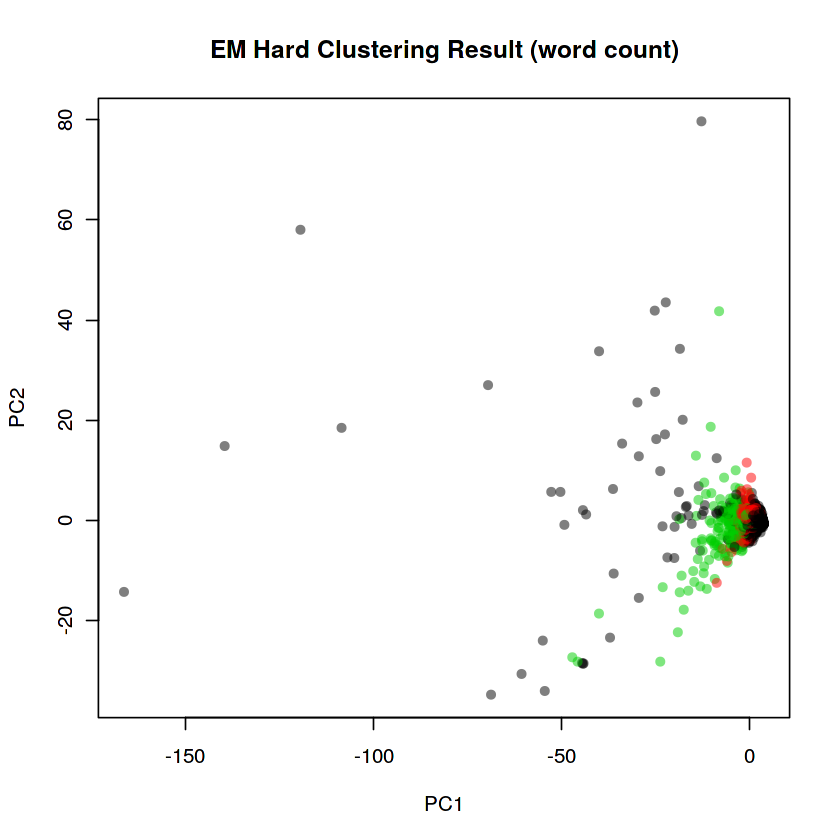

In [15]:

## plot the hardclustering outcome
plot(p.comp$x, col=adjustcolor(hardpost$cluster, alpha=0.5), pch=16,  main='EM Hard Clustering Result (word count)')

Each point only assigned to one cluster. Therefore, we do not see the any point with mixed colors.

In [16]:
# Wherever probabilities are <> 1 set them to zero
softpost.t <- t(softpost)
softpost.t[which(apply(softpost.t, 2, function(x) x != max(x,na.rm=TRUE)))] <- 0
softpost.t[which(apply(softpost.t, 2, function(x) x == max(x,na.rm=TRUE)))] <- 1
                        
softpost <- t(softpost.t)

#create dataframes of soft-clustering and cluster numbers
softcluster.df <- join(as.data.frame(softpost), as.data.frame(cluster.matrix), type="left")


Joining by: V1, V2, V3


In [17]:
#store the last colum for plotting
softpost$cluster <- softcluster.df[,ncol(softcluster.df)]

In [18]:
softpost$cluster[is.na(softpost$cluster)] <- sample(1:K,1)

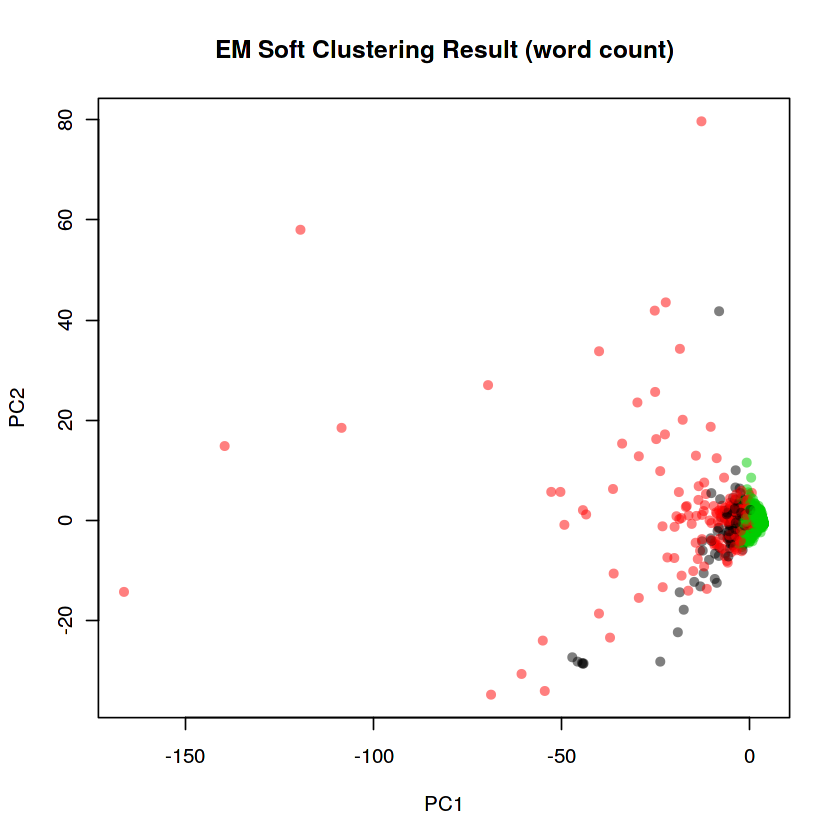

In [19]:

## plot the hardclustering outcome
plot(p.comp$x, col=adjustcolor(softpost$cluster, alpha=0.5), pch=16,  main='EM Soft Clustering Result (word count)')


The color code of the above figure(s) can be very different than the plot we draw using the real labels. This happens because the order of the estimated clusters may not be the same as the real order of the clusters.

As we observe in the plot(s), the intensity of the color of a particular point indicates the probability of that point being from the cluster which that color associated with. As a result, we see points with mixing colors 

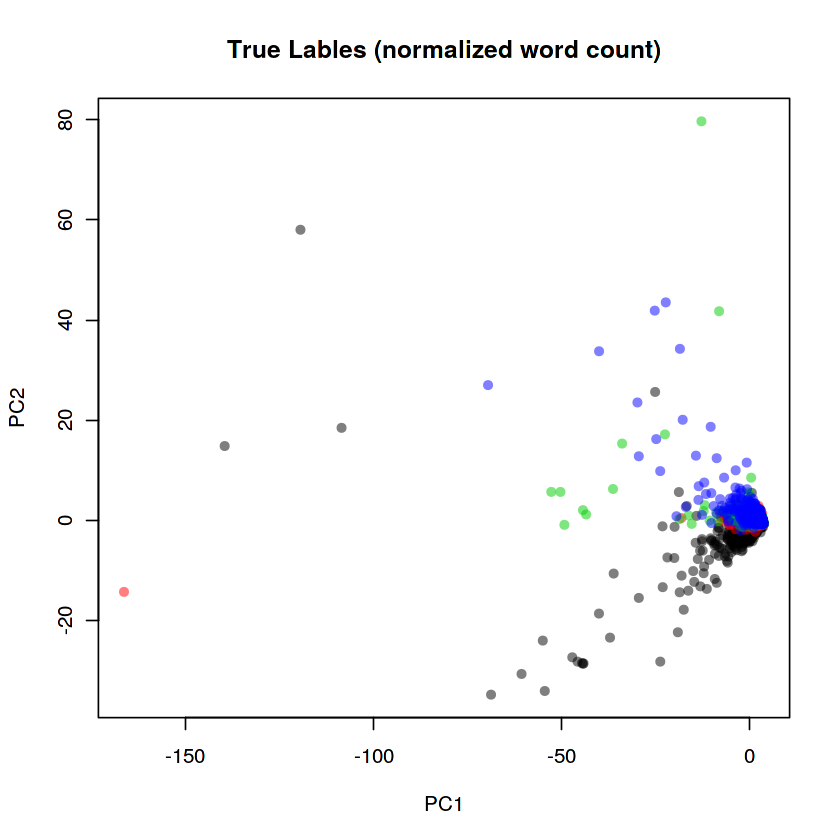

In [20]:
## plot the original labels to compare with the previous plot
plot(p.comp$x, col=adjustcolor(as.numeric(factor(labels)), 0.5), pch=16, main='True Lables (normalized word count)')

# Part B. Neural Network vs. Perceptron
In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.
## Question 2 [Neural Network’s Decision Boundary, 30 Marks]
1\. Load __Task3B_train.csv__ and Task3B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

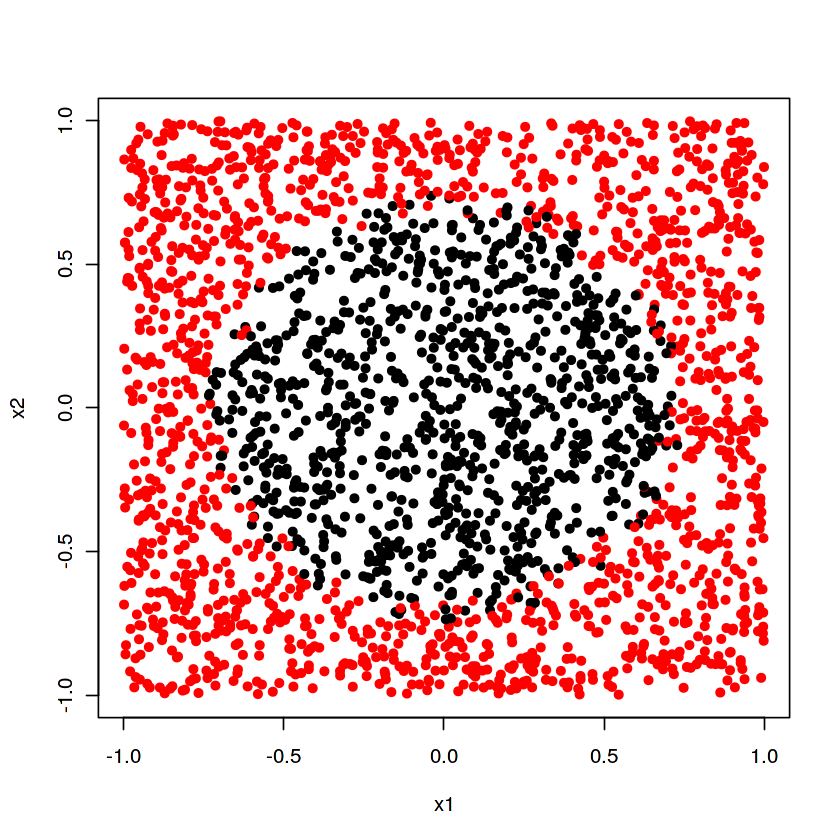

In [21]:
# Load data 
train.data <- read.csv("../Task3B_train.csv")
train.data <- train.data[complete.cases(train.data),]
train.features <- train.data[,1:2]
train.labels <- train.data[,3]

test.data <- read.csv("../Task3B_test.csv")
test.data <- test.data[complete.cases(test.data),]
test.features <- test.data[,1:2]
test.labels <- test.data[,3]

# Plot train.features
plot(train.features, pch=16, col=as.numeric(factor(train.labels)))

2\. Run the implementations of Perceptron given to you in Activity 3.1, calculate the test error, and plot the test data while the points are colored with their estimated class labels; attach the pdf to your report.


In [22]:
# creates the Phi matrix, setting X0 to 1
project_phi <- function(train.data) {
    return(as.matrix(cbind('X0'=1, train.data)))
}

perceptron <- function(features, labels, c0='1', c1='-1', eta=0.01, epsilon=0.001, tau.max=100) {
    train.len <- nrow(features)
    ## Basis function (Step 1)
    Phi <- project_phi(features)
    
    T <- ifelse(labels == c0, eval(parse(text=c0)),eval(parse(text=c1))) # Convention for class labels

    W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
    W[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

    error.trace <- matrix(0,nrow=tau.max, ncol=1) # Placeholder for errors
    error.trace[1] <- sum((Phi%*%W[1,])*T<0)/train.len*100 # record error for initial weights

    tau <- 1 # iteration counter
    terminate <- FALSE # termination status
    
    # Main Loop (Step 2):
    while(!terminate){
        # resuffling train data and associated labels:
        train.index <- sample(1:train.len, replace = FALSE)
        Phi <- Phi[train.index,]
        T <- T[train.index]
        
        for (i in 1:train.len){
            if (tau == tau.max) {break}
            # look for missclassified samples
            if ((W[tau,]%*%Phi[i,])*T[i]<0){
                # update tau counter
                tau <- tau +1

                # update the weights
                W[tau,] <- W[tau-1,] + eta * Phi[i,] * T[i]

                # update the records (training error)
                error.trace[tau] <- sum((Phi%*%W[tau,])*T<0)/train.len*100
            } 

        }

        # decrease eta:
        eta <- eta * 0.99
        # recalculate termination conditions
        terminate <- tau >= tau.max | abs(sum((Phi%*%W[tau,])*T<0)/train.len - sum((Phi%*%W[tau-1,])*T<0)/train.len) <= epsilon 

    }
    W <- W[1:tau,] # cut the empty part of the matrix (when the loop stops before tau == tau.max)
    return(list("coeff"=W[tau,],"error"=error.trace,"tau"=tau))
}

In [23]:
# Predict function for perceptron
predict <- function(features, weights, c0='1', c1='0') {
    predictions <- project_phi(features) %*% weights > 0
    return (ifelse(predictions, eval(parse(text=c0)),eval(parse(text=c1))))
}


In [24]:
#learn and capture weight vector & error df
trained.ptron <-  perceptron(train.features, train.labels)

trained.weights <-  trained.ptron$coeff
trained.error <-  trained.ptron$error
trained.tau <-  trained.ptron$tau

In [25]:
# Save test results for plotting
test.results <- as.data.frame(cbind(test.data,as.numeric(predict(test.features,trained.weights))))
names(test.results) <- c("x1","x2","y","y_predict")

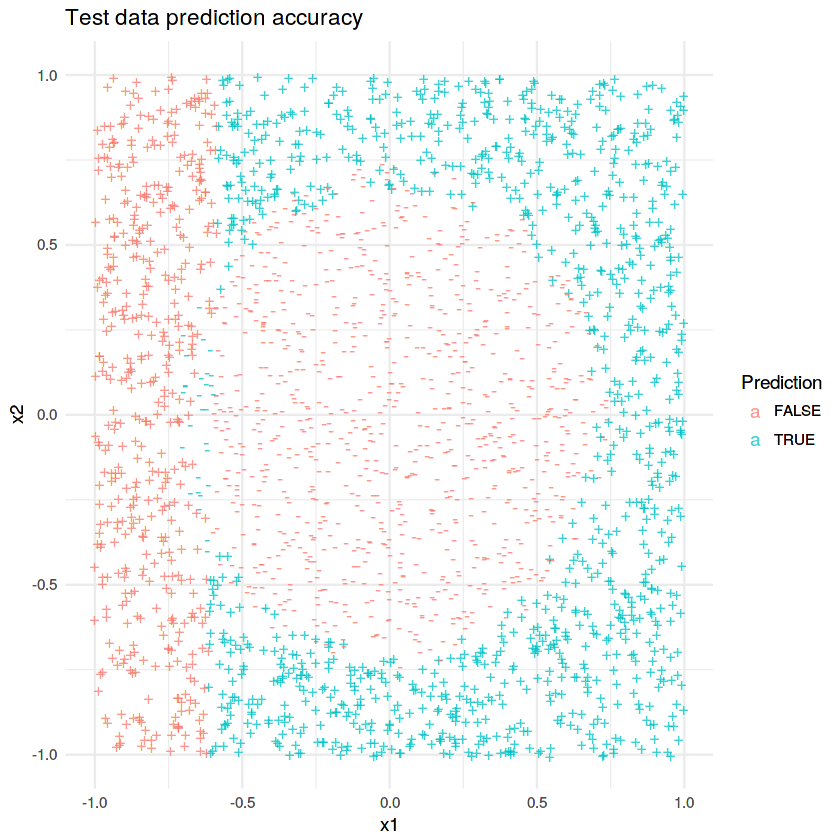

In [26]:
# Plot Test Data Prediction Accuracy
ggplot(data=test.results, aes(x=x1, y=x2, label=ifelse(y==0, '-', '+'), color=factor(y == y_predict))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Test data prediction accuracy') +
    theme_minimal()


In [27]:
# Obtain the accuracy of  training dataset
train.results <- as.data.frame(cbind(as.numeric(train.labels), as.numeric(predict(train.features, trained.weights))))
names(train.results) <- c("y", "y_predict")

# compare actual labels and predicted labels
train.match <- train.results$y == train.results$y_predict

#obtain accuracy of True Predicted Labels for Train
train.accuracy <- sum(train.match [train.match == TRUE])/length(train.match)

In [28]:
# Obtain the accuracy of test datasets

# compare actual labels and predicted labels
test.match <- test.results$y == test.results$y_predict

#obtain accuracy of True Predicted Labels for Test
test.accuracy <- sum(test.match [test.match == TRUE])/length(test.match)

In [29]:
cat("Perceptron training set accuracy: ", (train.accuracy)*100, "%\n")
cat("Perceptron test set accuracy: ", (test.accuracy)*100, "%")

Perceptron training set accuracy:  42.48 %
Perceptron test set accuracy:  43.32 %

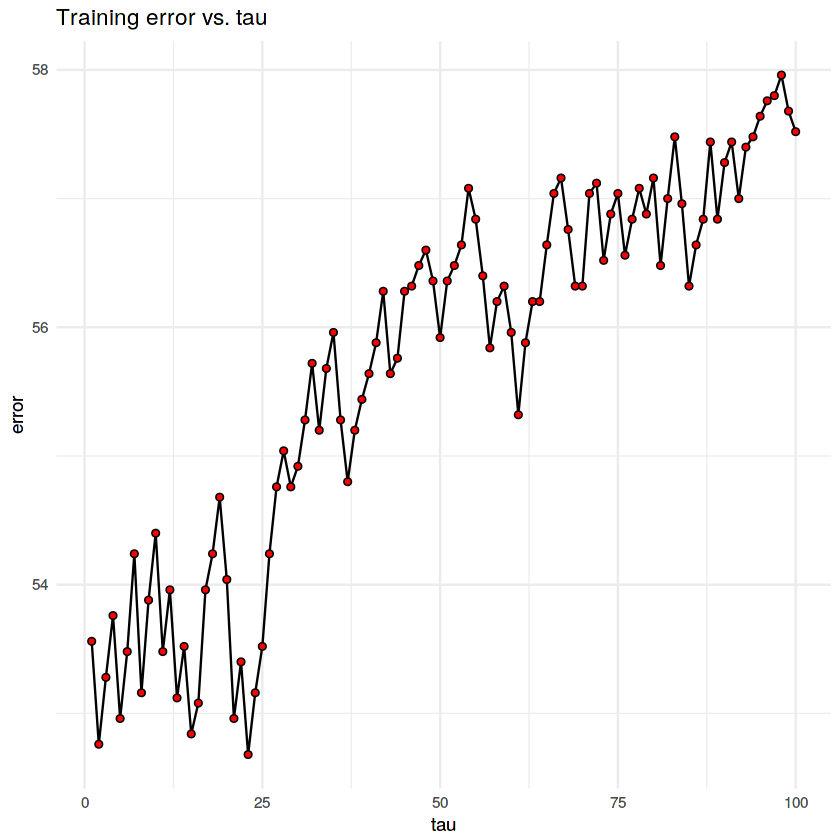

In [30]:
## merging and melting for  error visualizations
err <- data.frame('tau'=1:trained.tau)
err$error <- trained.error[1:trained.tau]

err.m <- melt(err, id=c('tau', 'error'))
## Training error
ggplot(data=err.m,aes(x=tau, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Training error vs. tau') + theme_minimal()

3\. Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected.

In [31]:
# Load h20 and init cluster
library(h2o)
# If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
# You may need to change the h2o.inint paramter values
localH2O =  h2o.init(nthreads = -1, port = 54399, max_mem_size = '3G', startH2O = TRUE)



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    ||, &&, %*%, apply, as.factor, as.numeric, colnames, colnames<-,
    ifelse, %in%, is.character, is.factor, is.numeric, log, log10,
    log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpPmgRsS/h2o_asuv0002_started_from_r.out
    /tmp/RtmpPmgRsS/h2o_asuv0002_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 923 milliseconds 
    H2O cluster version:        3.14.0.3 
    H2O cluster version age:    10 months and 16 days !!! 
    H2O cluster name:           H2O_started_from_R_asuv0002_rjl243 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.67 GB 
    H2O cluster total cores:    32 
    H2O cluster allowed cores:  32 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54399 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.3 

In [35]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

##########################

In [36]:
# Load data
train.data.h2o <- na.omit(h2o.importFile('../Task3B_train.csv'))
test.data.h2o <- na.omit(h2o.importFile('../Task3B_test.csv'))
train.data.h2o[,3] <- as.factor(train.data.h2o[,3])
test.data.h2o[,3] <- as.factor(test.data.h2o[,3])

  |======================================================================| 100%
  |======================================================================| 100%


In [37]:
# Initialize defaults and set K
K <- 1:20

train.error <-data.frame( k=1:length(K),error=rep(0, length(K)))
test.error  <-data.frame( k=1:length(K),error=rep(0, length(K)))

nn.model.evaluation <- data.frame(
    k=rep(0, length(K)), train.accuracy=rep(0, length(K)), test.accuracy=rep(0, length(K)))

best.prediction <- 0
best.accuracy <- 0
best.k <- 0

In [38]:
# This step may take a few minute to complete!

for (k in K) {
    mdl <-  h2o.deeplearning(
    x=1:2, #select x1, x2
    y="y", #select y column
    training_frame = train.data.h2o, #training dataframe
    hidden = c(k), #3 layer NN
    epochs = 100, #maximum number of epochs
    activation = 'Tanh', #activation function
    autoencoder = FALSE
    )
    
    
    test.pred <- h2o.predict(mdl, test.data.h2o)$predict
    train.pred <- h2o.predict(mdl, train.data.h2o)$predict
    
    test.results <- cbind(as.data.frame(test.data.h2o), predict=as.matrix(test.pred))
    train.results <- cbind(as.data.frame(train.data.h2o), predict=as.matrix(train.pred))
    
    accuracy.test <- sum(test.results$y == test.results$predict) / nrow(test.results)
    accuracy.train <- sum(train.results$y == train.results$predict) / nrow(train.results)
    
    
    train.error[k,2] =  error.rate(train.pred, train.data.h2o[,3])
    test.error[k,2] =  error.rate(test.pred, test.data.h2o[,3])
    
    nn.model.evaluation[k,] <- c(k, accuracy.train, accuracy.test)
    
    # Find and record best k and test results
    if (accuracy.test > best.accuracy) {
        best.accuracy <- accuracy.test
        best.prediction <- accuracy.train - accuracy.test
        best.k <- k
    }
}
cat("The best choice of k is ", best.k, ", with a validation set accuracy of ", (best.accuracy * 100), "%\n")

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [39]:
# Reshape Data
nn.model.eval.m <- melt(nn.model.evaluation, id="k" , value.name = "accuracy")


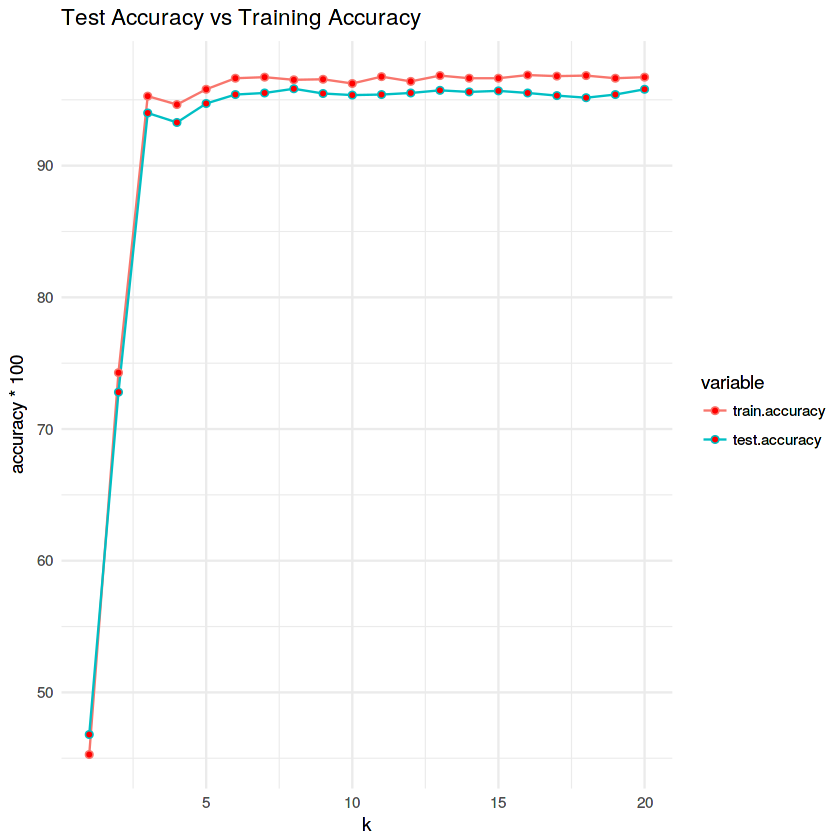

In [41]:
# plot test and training accuracy:
ggplot(data=nn.model.eval.m,aes(x=k, y=accuracy*100, colour = variable)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Test Accuracy vs Training Accuracy') + theme_minimal()

4\. In a table, report the error rates obtained by the perceptron and all variants of NN. Then bold the best model (with minimum error).


In [42]:
# Combine perceptron and h2o error rates
perceptron.train.err <- data.frame("k"=err.m[1],type="perceptron",error=err.m[2])
colnames(perceptron.train.err) <- c("k","type","error")
h2o.train.error <- data.frame(k=train.error[1],type="h2o",error=train.error[2]*100)
compare.err <- rbind(perceptron.train.err,h2o.train.error)

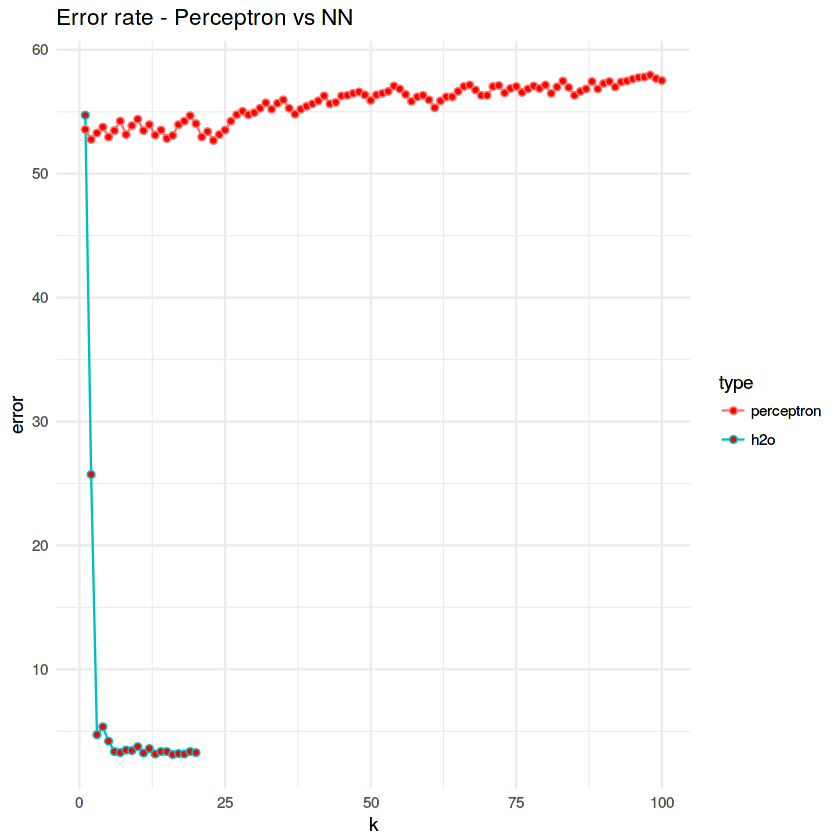

In [43]:
# Plot Perceptron vs h20 error
ggplot(data=compare.err,aes(x=k, y=error, colour = type)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Error rate - Perceptron vs NN') + theme_minimal()

In this table...

In [44]:
# Display K where error is at minimum
compare.err[which.min(compare.err$error),]

,k,type,error
116,16,h2o,3.12


In [45]:
# Plot the data and color them differently, if they are classified correctly or incorrectly
    mdl <-  h2o.deeplearning(
    x=1:2, #select x1, x2
    y="y", #select y column
    training_frame = train.data.h2o, #training dataframe
    hidden = c(18), #3 layer NN
    epochs = 100, #maximum number of epochs
    activation = 'Tanh', #activation function
    autoencoder = FALSE
    )

    test.pred <- h2o.predict(mdl, test.data.h2o)$predict
    test.results <- cbind(as.data.frame(test.data.h2o), predict=as.matrix(test.pred))

summary(mdl)


  |======================================================================| 100%
  |======================================================================| 100%
Model Details:

H2OBinomialModel: deeplearning
Model Key:  DeepLearning_model_R_1533646322834_106 
Status of Neuron Layers: predicting y, 2-class classification, bernoulli distribution, CrossEntropy loss, 92 weights/biases, 3.9 KB, 250,000 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1     2   Input  0.00 %                                              
2     2    18    Tanh  0.00 % 0.000000 0.000000  0.001412 0.000950 0.000000
3     3     2 Softmax         0.000000 0.000000  0.003211 0.001292 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.148683   0.867686  0.338319 1.113171
3    0.057166   2.103197  0.017512 2.067205

H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics report

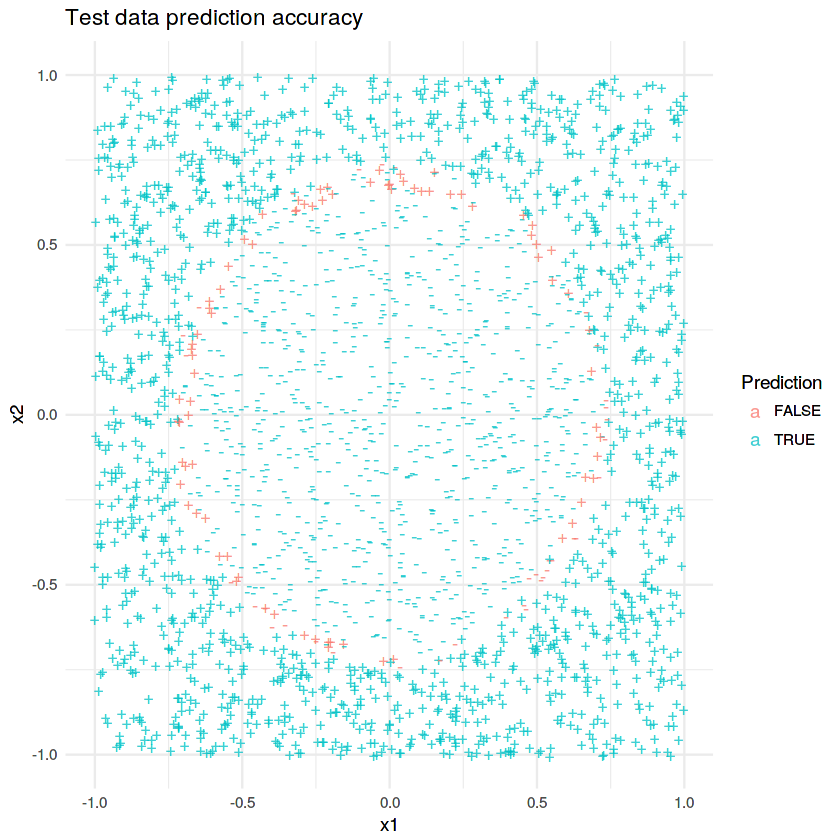

In [46]:
# Plot Test Data Prediction Accuracy on NN
ggplot(data=test.results, aes(x=x1, y=x2, label=ifelse(y==0, '-', '+'), color=factor(y == predict))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Test data prediction accuracy') +
    theme_minimal()


5\. Explain the reason(s) responsible for such difference between perceptron and a 3-layer NN. Providing references and using diagrams are recommended.

__Hint:__ Look at the plots and think about the model assumptions.

In step 1 of Part B, when we plotted the train features, we reviewed that the data is not linearly separable i.e.,  label 1 was at the center and label 2 surrounding it. Perceptron works well with linearly separable binary classifications, which is evident in the 'Perceptron' test prediction accuracy plot. You could clearly see at separation in the plot as a linear geom_line and based on the class, anything on either side of the line were incorrectly predicted.

But in case of NN, we picked a linearly non separable implementation, and the predictions were almost accurate.
More details on the reference 3 below.

References:

1. https://www.researchgate.net/post/With_respect_to_non-linear_separable_problem_classifications_is_Perceptron_or_SVM_preferable
2. https://www.quora.com/Is-it-true-that-single-layer-perceptrons-are-only-capable-of-learning-linearly-separable-data
3. https://medium.com/@vivek.yadav/how-neural-networks-learn-nonlinear-functions-and-classify-linearly-non-separable-data-22328e7e5be1


# Part C. Self-Taught Learning
In this part, you implement self-taught learning for Neural Network using the Autoencoder that provided in Activity 5.2 and the 3-layer NN from Activity 5.1.
## Question 3 [Self Taught Neural Network Learning, 30 Marks]

__Hint.__ Since the dataset for this task is large and high-dimensional, running the whole
experiments several times is very time consuming. Therefore, it is recommended to only use a small portion of your data when you develop or debug your code.

__Hint.__ If you can combine Step II and V (so learn each autoencoder only once), you may save a great portion of the execution time.

__Hint.__ If you don’t see the expected behaviour in your plots, you may need to check that the data is clean, i.e. it does'nt have NA entries, it’s normalised etc. Moreover, you may need to check that your implementation of the model and training/decoding algorithms is correct.

1\. Load __Task3C_labeled.csv__, __Task3C_unlabeled.csv__ and __Task3C_test.csv__ data sets and required libraries (e.g., H2O). __Note__ that we are going to use __Task3C_labeled.csv__ and __Task3C_unlabeled.csv__ for training the autoencoder. We are going to use Task3C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task3C_test.csv.

In [47]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

##########################


# 1. Load the data
labeled.frame <- h2o.importFile(path = '../Task3C_labeled.csv' ,sep=',')
unlabeled.frame <- h2o.importFile(path = '../Task3C_test.csv' ,sep=',')
test.frame <- h2o.importFile(path = '../Task3C_unlabeled.csv' ,sep=',')


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [48]:
# Drop NAs
labeled.frame <-h2o.na_omit(labeled.frame)
unlabeled.frame <-h2o.na_omit(unlabeled.frame)
test.frame <- h2o.na_omit(test.frame)

In [49]:
# Change data type as necessary
labeled.frame[,1] <- as.factor(labeled.frame[,1] )
labeled.frame[,2:ncol(labeled.frame)] <- as.numeric(labeled.frame[,2:ncol(labeled.frame)])


unlabeled.frame[,1] <- NA
unlabeled.frame[,2:ncol(unlabeled.frame)] <-  as.numeric(unlabeled.frame[,2:ncol(unlabeled.frame)])


test.frame[,1] <-  as.factor(test.frame[,1] )
test.frame[,2:ncol(test.frame)] <-  as.numeric(test.frame[,2:ncol(test.frame)])


# Create a train frame
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])


In [50]:
# Scale and Normalize Train Frame
train.frame <-h2o.scale(train.frame, center = TRUE, scale = TRUE)

2\. Build an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons from 2 to 50.

In [51]:
# Initialize the errors data frame
errors <-  data.frame(features=(ncol(test.frame)-1),error=as.numeric(0))

In [52]:
# 4. Build a classifier
NN.model.classifier = h2o.deeplearning(     
    x = 2:785, # select all pixels
    y = 1,
    training_frame = labeled.frame, # specify the frame (imported file)    
    hidden = c(10), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function  
    ignore_const_cols = FALSE,
    autoencoder = FALSE # is it an autoencoder? No!
)

  |======================================================================| 100%


In [53]:
#Capture ordinary classification error
ordinary.classification.error <- error.rate(h2o.predict(NN.model.classifier, test.frame)$predict, test.frame[,1])

  |======================================================================| 100%


In [54]:
errors[errors$features == 784,2] <- ordinary.classification.error
cat("Classification error without augmented features: ", ordinary.classification.error)

Classification error without augmented features:  0.27


3\. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. 



4\. Use the 3-layer NN from Activity 3.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) build a model with 10 units in the hidden layer. Then, calculate and record the test error.



5\. Build augmented self-taught networks using the models learnt in Step II. For each model:
   1. Add the output of the middle layer as extra features to the original featureset, 
   2. Train a 3-layer NN (similar to Step IV) using all features (original + extra).Then calculate and record the test error.

In [55]:
# This step may take a few minutes to run
reconstruction.error <- data.frame(k=2:50, error=rep(0, 49))
# For autoencoder hidden layer size of k...
for (k in 2:50) {
    # Build an autoencoder using the labeled and unlabeled datasets...
    NN.model <- h2o.deeplearning(    
         x = 1:784, # select all pixels
         training_frame = train.frame, # specify the frame (imported file)    
         hidden = c(k), # number of layers and their units
         epochs = 100, # maximum number of epoches  
         activation = 'Tanh', # activation function  ,
         ignore_const_cols = FALSE,
         autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    
    reconstruction.error[reconstruction.error$k==k,2] <- mean(h2o.anomaly(NN.model, train.frame))
    
    # Extract the middle layer for the labeled data set...
    middle.layer <- h2o.deepfeatures(NN.model, labeled.frame, layer=1)
  
    # Augment the features of the labeled data set with the learnt features...
    new.features <- append(setdiff(colnames(labeled.frame), "label"),colnames(middle.layer))
    
    # Train a new classifier using the augmented features...  
    NN.model.classifier = h2o.deeplearning(y = "label",
                               x = new.features,
                               training_frame = h2o.cbind(labeled.frame,middle.layer),
                               #reproducible = TRUE, #slow - turn off for real problems
                               #balance_classes = TRUE,
                               #ignore_const_cols = FALSE,
                               #seed = 42,
                               hidden = c(10), 
                               epochs = 300,
                               activation = "Tanh",
                               autoencoder = FALSE
                            )
    
    # Calculate and record the classification error...
    errors[784 + k, 1] <- 784+k
    errors[784 + k, 2] <- error.rate(h2o.predict(NN.model.classifier, test.frame)$predict, test.frame[,1])
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

6\. Plot the error rates for the 3-layer neural networks from Step IV and V while the x-axis is the number of features and y-axis is the classification error. 

In [56]:
# emit NAs from the errors
model.errors <- na.omit(errors)

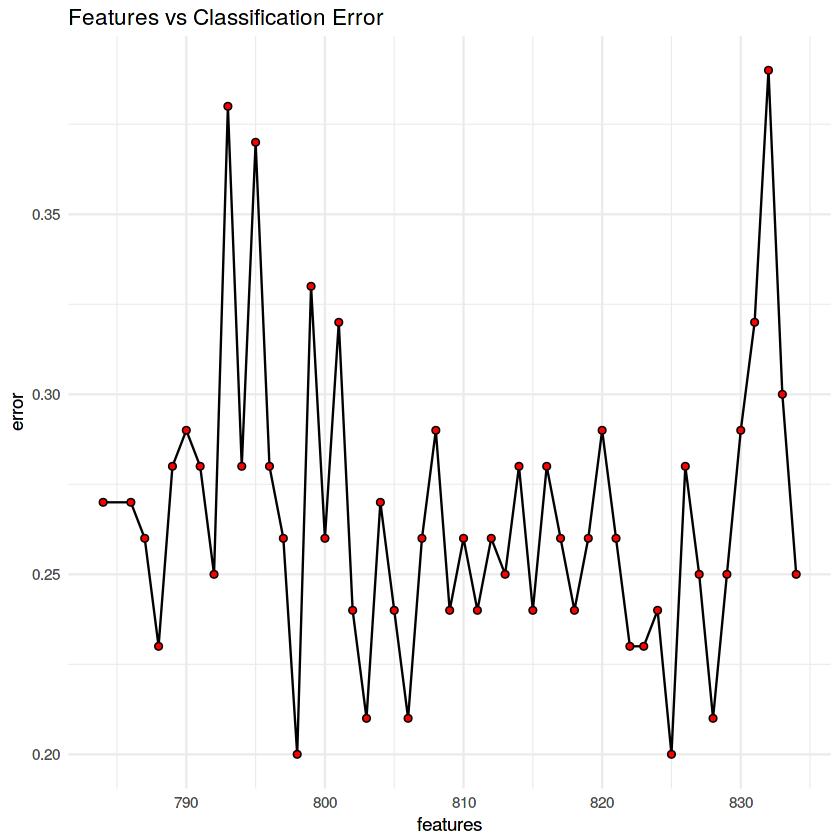

In [57]:
#Plot new features vs classification error
ggplot(data=model.errors,aes(x=features, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Features vs Classification Error') + theme_minimal()

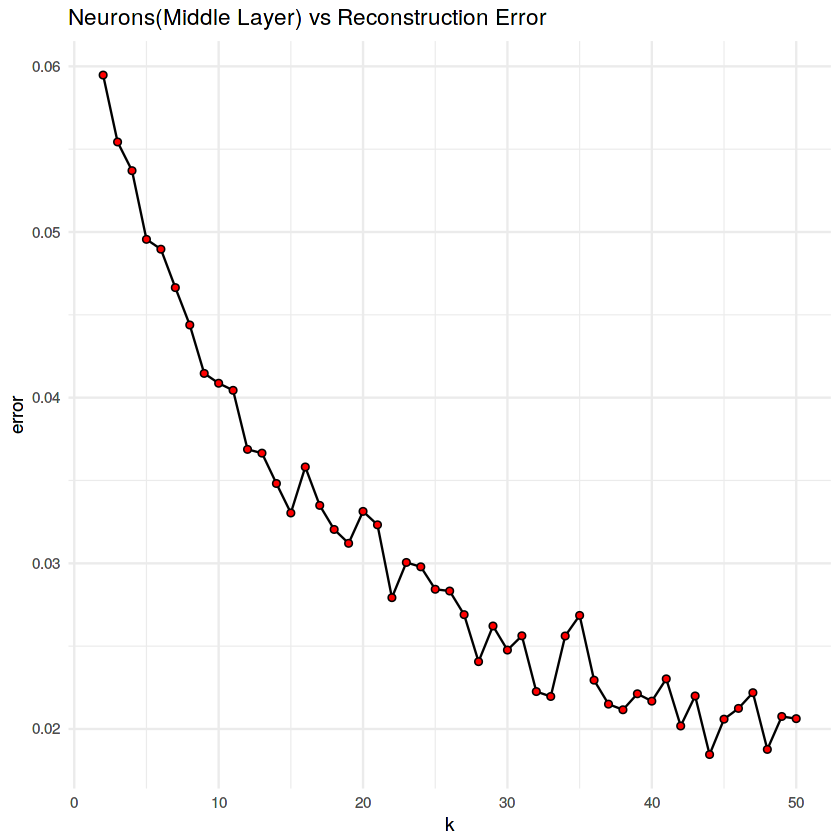

In [58]:
# Plot for reconstruction error for all values of K in the middle layer (neurons)
ggplot(data=reconstruction.error,aes(x=k, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Neurons(Middle Layer) vs Reconstruction Error') + theme_minimal()

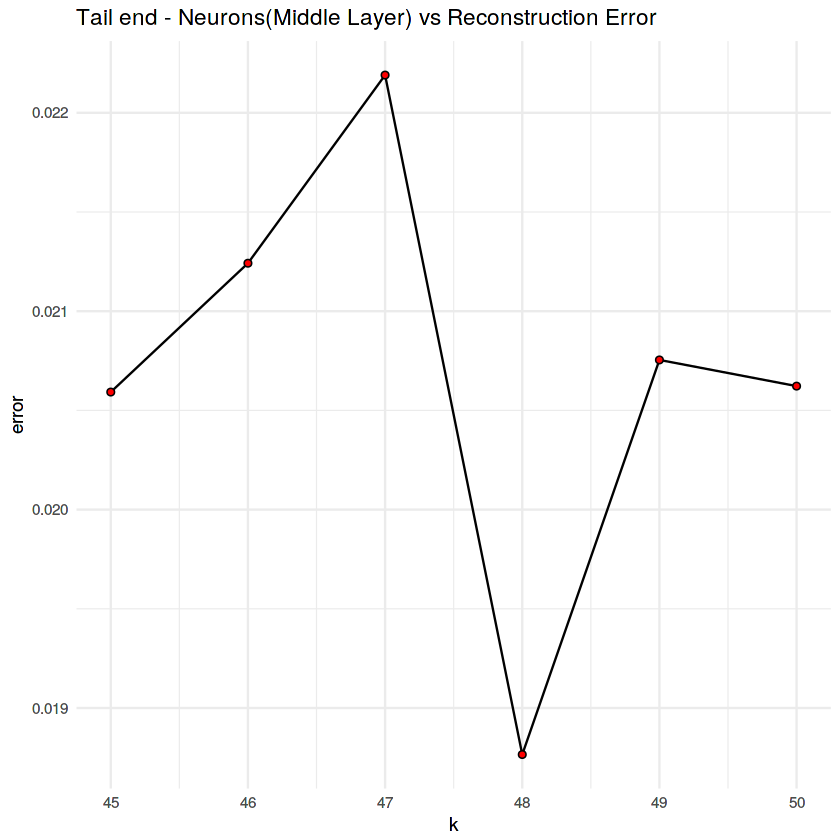

In [59]:
# Plotting the tail to check if the autoencoder is still improving when k moves towards K(50)
ggplot(data=tail(reconstruction.error),aes(x=k, y=error)) + geom_line() + geom_point(shape=21, fill='red')  +
    ggtitle('Tail end - Neurons(Middle Layer) vs Reconstruction Error') + theme_minimal()

7\. Report the optimum number(s) of units in the middle layer of the autoencoder in terms of the reconstruction and misclassification errors.

In [60]:
# Maximum Missclassification Error
model.errors[which.max(model.errors$error),]

,features,error
832,832,0.39


In [61]:
# Minimum Missclassification Error
model.errors[which.min(model.errors$error),]

,features,error
798,798,0.2


In terms of the autoencoder's reconstruction error, ...

In [62]:
# Maximum Reconstruction Error
reconstruction.error[which.max(reconstruction.error$error),]

k,error
2,0.05947385


In [63]:
#Minimum Reconstruction Error
reconstruction.error[which.min(reconstruction.error$error),]

,k,error
43,44,0.01845647


In [64]:
# Regeneration model for optimal K = 42 for visualization
# Ideally, we should capture the results the when the autoencoder runs and display it out.

# Hidden value = feature number when k is lowest - total features in original dataset

NN.model <- h2o.deeplearning(  x = 1:784, training_frame = train.frame,  hidden = c(826-784), epochs = 100, activation = 'Tanh', ignore_const_cols = FALSE,autoencoder = TRUE )
middle.layer <- h2o.deepfeatures(NN.model, labeled.frame, layer=1)
new.features <- append(setdiff(colnames(labeled.frame), "label"),colnames(middle.layer))
NN.model.classifier = h2o.deeplearning(y = "label", x = new.features, training_frame = h2o.cbind(labeled.frame,middle.layer), hidden = c(10),  epochs = 300,  activation = "Tanh", autoencoder = FALSE )

predictor.op <- as.vector(h2o.predict(NN.model.classifier, test.frame)$predict)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


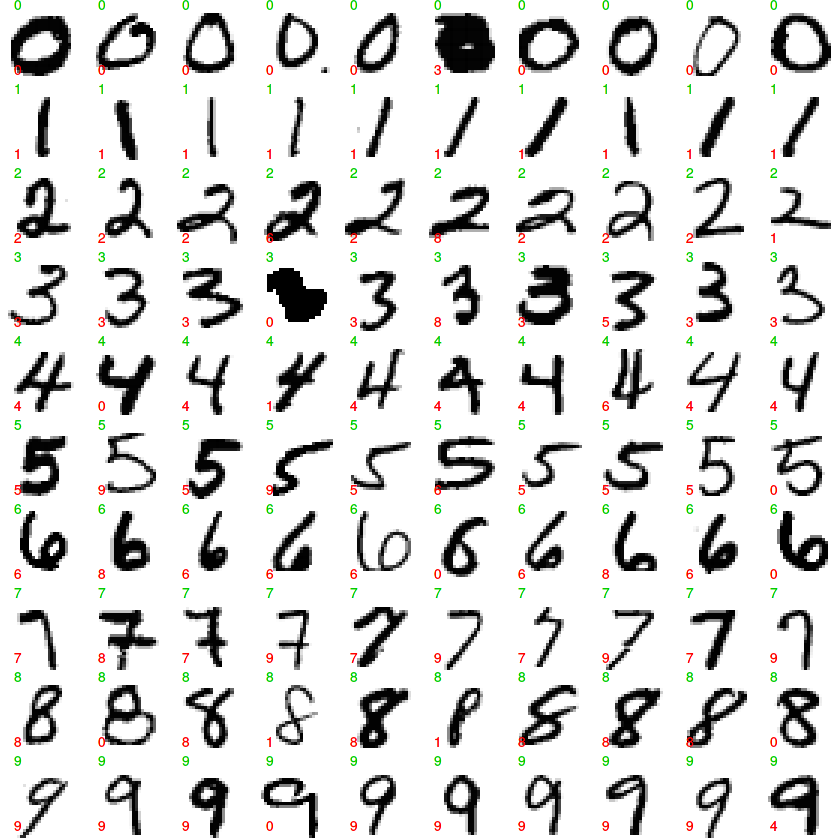

In [65]:
#visualize prediction at optimal K
par( mfrow = c(10,10), mai = c(0,0,0,0))
for(i in 1:100){
  y <- as.matrix(test.frame[i, 2:785])
  dim(y) <- c(28, 28)
  image( y[,nrow(y):1], axes = FALSE, col = gray(255:0 / 255))
  text( 0.2, 0.8, test.frame[i,1], cex = 1, col = 3, pos = c(3,4))
  text( 0.2, 0, predictor.op[i], cex = 1, col = 2, pos = c(3,4))
}


In the above plot, the green text is the actual response of the image, while the red text is the predicted reponse.

8\. Comparing the plot from Step III and VI, do you observe any relation between the reconstruction error and misclassification error? Explain your findings.

There is no observable relationship between reconstruction and misclassification errors. 

Reconstruction is to do with the error during the reduction of dimensionality of the input and then reconstruct the original input given a training dataset, while misclassification is to do with the prediction of response variable given the test output.

Reconstruction error definitely minimizes as K increases and moves toward the epoch, irrespective of the size of the training dataset while the missclassification error would reduce based on the size of the data trained i.e., because we would build our classifier based on a better model.

In [ ]:
#Clean Up
#rm(list=ls()) # Clean up unnecessary variables.

Assignment References:

1. https://shiring.github.io/machine_learning/2017/05/01/fraud

2. https://rdrr.io/cran/h2o/man/h2o.scale.html

3. https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

4. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.74.857&rep=rep1&type=pdf

5. https://github.com/rstudio/keras/issues/94

6. https://github.com/erichson/spca

7. https://stats.stackexchange.com/questions/194278/meaning-of-reconstruction-error-in-pca-and-lda

8. https://shiring.github.io/machine_learning/2017/02/27/h2o

9. https://www.r-bloggers.com/a-little-h2o-deeplearning-experiment-on-the-mnist-data-set/

10. http://amunategui.github.io/anomaly-detection-h2o/

11. https://www.h2o.ai/wp-content/uploads/2018/01/RBooklet.pdf

12. https://github.com/h2oai/h2o-3/blob/master/h2o-r/tests/testdir_algos/deeplearning/runit_deeplearning_anomaly_large.R
